In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Features overview
## Feature long list catagories:

>### Player details (as of most recent week)
- ICT scores
- Selected (by other FPL players)
- Player value


>### Details of fixture - FIX
- Relative strength of teams
    - Position in league
    - Team strength stats in teams csv
- Home or away
- Forecasted minutes played

>### Player's recent performance (LW = last week)
- Points
- Goals
- Bonus points
- Red/yellow cards
- Own goals
- Saves (GK only)
- Goals conceded (GK, Def)
- Clean sheets (GK, Def, MF)
- 

>### Player's recent performance (L4W = last 4 weeks)
- Average (and stdev) of 
    - Points
    - Goals
    - Bonus points
    - Red/yellow cards
    - Own goals
    - Saves (GK only)
    - Goals conceded (GK, Def)
    - Clean sheets (GK, Def, MF)


>### Player's performance across the season (TSS = This season)
- Average (and stdev) of 
    - Points
    - Goals
    - Bonus points
    - Red/yellow cards
    - Own goals
    - Saves (GK only)
    - Goals conceded (GK, Def)
    - Clean sheets (GK, Def, MF)



>### Player's historic performance (LSS_H = last season)
- Average (and stdev) of 
    - Points
    - Goals
    - Bonus points
    - Red/yellow cards
    - Own goals
    - Saves (GK only)
    - Goals conceded (GK, Def)
    - Clean sheets (GK, Def, MF)

## Target
- Total points


# Data addresses

In [3]:
this_season_folder = "/Users/calumthompson/Documents/Fantasy football/GitHub_data/data/2019-20/"
last_season_folder = "/Users/calumthompson/Documents/Fantasy football/GitHub_data/data/2018-19/"

In [4]:
team_link = "teams.csv"

In [5]:
players_raw = "players_raw.csv"

In [6]:
fixtures_link = 'https://fixturedownload.com/download/epl-2019-GMTStandardTime.csv'

In [7]:
table_link = "https://www.footballwebpages.co.uk/league-table.csv?comp=1&showHa=yes"

# 1. Create fixtures data for each player 
## 1.1. The spine of the data is the fixtures list

In [8]:
Date_format = lambda x: pd.datetime.strptime(x, "%d/%m/%Y %H:%M")
fixtures_RAW = pd.read_csv(fixtures_link,parse_dates = ['Date'], date_parser = Date_format)
fixtures_RAW.head()

,Round Number,Date,Location,Home Team,Away Team,Result
0,1,2019-08-09 20:00:00,Anfield,Liverpool,Norwich,4 - 1
1,1,2019-08-10 12:30:00,London Stadium,West Ham,Man City,0 - 5
2,1,2019-08-10 15:00:00,Vitality Stadium,Bournemouth,Sheffield Utd,1 - 1
3,1,2019-08-10 15:00:00,Turf Moor,Burnley,Southampton,3 - 0
4,1,2019-08-10 15:00:00,Selhurst Park,Crystal Palace,Everton,0 - 0


In [9]:
fixtures_RAW[['home_score' , 'away_score']] = fixtures_RAW['Result'].str.split(' - ', expand = True)
teams = fixtures_RAW['Home Team'].unique()

merge = []


# Transform into indivdual team fixtures
for team in teams:
        
    team_record = fixtures_RAW.loc[(fixtures_RAW['Home Team'] == team) | (fixtures_RAW['Away Team'] == team)]

    col_team = np.full(38, team)
    col_GWs = np.arange(1,39)
    col_Opponent = np.where(team_record['Home Team'] == team, team_record['Away Team'],team_record['Home Team'])
    col_home = np.where((team_record['Home Team'] == team), 1 , 0)
    col_date = team_record['Date'].dt.date
    col_goals = np.where((team_record['Home Team'] == team), team_record['home_score'], team_record['away_score']) 
    col_opp_goals = np.where((team_record['Home Team'] == team), team_record['away_score'], team_record['home_score'])

    col_points = np.where(col_goals > col_opp_goals, 3, 
                                 np.where(col_goals == col_opp_goals, 1, col_goals))

    team_record = pd.DataFrame({'PLAYER_Team':col_team,'PLAYER_GW':col_GWs,'PLAYER_Fixture_date':col_date
                                ,'PLAYER_Opponent':col_Opponent,'FIX_Home?':col_home
                                ,'TEMP_team_goals' : col_goals, 'TEMP_opp_goals' : col_opp_goals, 'TEMP_points_gained' : col_points })
    
    merge.append(team_record)
    
fixtures_df = pd.concat(merge).reset_index(drop = True)    


# Compute team relative scores

fixtures_df['TEMP_goals_last_week'] = fixtures_df.groupby('PLAYER_Team')['TEMP_team_goals'].shift(periods = 1 )
fixtures_df['TEMP_cumulative_goals_incoming'] = fixtures_df.groupby('PLAYER_Team')['TEMP_goals_last_week'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_Team'], drop = True)

fixtures_df['TEMP_points_last_week'] = fixtures_df.groupby('PLAYER_Team')['TEMP_points_gained'].shift(periods = 1 )
fixtures_df['TEMP_cumulative_points_incoming'] = fixtures_df.groupby('PLAYER_Team')['TEMP_points_last_week'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_Team'], drop = True)


# Fill in table points for opposing teams

fixt_duplicate = fixtures_df.copy()[['PLAYER_Team','PLAYER_Fixture_date','TEMP_cumulative_goals_incoming','TEMP_cumulative_points_incoming']]
fixt_duplicate = fixt_duplicate.rename(columns = {'PLAYER_Team' : 'PLAYER_Opponent'
                                                 ,'TEMP_cumulative_goals_incoming': 'TEMP_opp_goals_incoming'
                                                 ,'TEMP_cumulative_points_incoming' : 'TEMP_opp_points_incoming'})

fixtures_df = pd.merge(fixtures_df,fixt_duplicate)


fixtures_df['FIX_avg_point_difference'] = fixtures_df['TEMP_cumulative_points_incoming'] - fixtures_df['TEMP_opp_points_incoming']
fixtures_df['FIX_avg_goal_difference'] = fixtures_df['TEMP_cumulative_goals_incoming'] - fixtures_df['TEMP_opp_goals_incoming']


fixtures_df = fixtures_df[[c for c in fixtures_df.columns if str.startswith(c, 'TEMP') == False]]

fixtures_df.head()


,PLAYER_Team,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent,FIX_Home?,FIX_avg_point_difference,FIX_avg_goal_difference
0,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN
1,Liverpool,2,2019-08-17,Southampton,0,3.000000,4.000000
2,Liverpool,3,2019-08-24,Arsenal,1,0.000000,1.500000
3,Liverpool,4,2019-08-31,Burnley,0,1.333333,1.333333
4,Liverpool,5,2019-09-14,Newcastle,1,1.750000,2.250000


## 1.2. Map to Vaastav's team ids 

In [10]:
Vaastav_teams = pd.read_csv(this_season_folder+team_link, usecols = ['id','name'])
Team_keys = dict(zip(Vaastav_teams['name'], Vaastav_teams['id']))

In [11]:
## fixtures_df['Team_id'] = fixtures_df['Team'].map(Team_keys)
fixtures_df['PLAYER_Opponent_id'] = fixtures_df['PLAYER_Opponent'].map(Team_keys)
fixtures_df.head()

,PLAYER_Team,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent,FIX_Home?,FIX_avg_point_difference,FIX_avg_goal_difference,PLAYER_Opponent_id
0,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14
1,Liverpool,2,2019-08-17,Southampton,0,3.000000,4.000000,16
2,Liverpool,3,2019-08-24,Arsenal,1,0.000000,1.500000,1
3,Liverpool,4,2019-08-31,Burnley,0,1.333333,1.333333,5
4,Liverpool,5,2019-09-14,Newcastle,1,1.750000,2.250000,13


## 1.3. Match players to team
As players do not have a team column, join on opponent at given date

In [12]:
merged_gw_cols = pd.read_csv(this_season_folder + "gws/merged_gw.csv", parse_dates = ['kickoff_time'])
merged_gw_cols['Fixture_date'] = merged_gw_cols['kickoff_time'].dt.date 
merged_gw_cols = merged_gw_cols.sort_values(['Fixture_date','name']) 
merged_gw_cols.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,Fixture_date
7,Adam_Lallana_195,0,0,0,0,0.0,195,1,0,0,0.0,0.0,2019-08-09 19:00:00+00:00,0,14,0,0,0,0,1,0,7143,1.0,4.0,0.0,0,0,0,0,60,True,0,1,2019-08-09
13,Adrián_San Miguel del Castillo_526,0,0,7,0,0.0,526,1,1,0,1.1,10.6,2019-08-09 19:00:00+00:00,51,14,0,0,0,0,1,2,0,1.0,4.0,0.0,1,0,0,0,45,True,0,1,2019-08-09
23,Alex_Oxlade-Chamberlain_193,0,0,0,0,0.0,193,1,0,0,0.0,0.0,2019-08-09 19:00:00+00:00,0,14,0,0,0,0,1,0,28598,1.0,4.0,0.0,0,0,0,0,65,True,0,1,2019-08-09
17,Alexander_Tettey_289,0,0,0,0,0.0,289,1,0,0,0.0,0.0,2019-08-09 19:00:00+00:00,0,10,0,0,0,0,1,0,10849,1.0,4.0,0.0,0,0,0,0,45,False,0,1,2019-08-09
25,Alisson_Ramses Becker_189,0,0,7,0,0.0,189,1,0,0,0.6,5.6,2019-08-09 19:00:00+00:00,38,14,0,0,0,0,1,2,1769075,1.0,4.0,0.0,1,0,0,0,60,True,0,1,2019-08-09


In [13]:
players_df = merged_gw_cols#[['name','opponent_team', 'minutes', 'Fixture_date','total_points']]
players_df = players_df.rename(columns  = {'name' : 'PLAYER_name'
                                          ,'minutes' : 'TARGET_minutes'
                                          ,'Fixture_date' :'PLAYER_Fixture_date'
                                          ,'total_points' : 'TARGET_total_points'
                                          ,'opponent_team' : 'PLAYER_Opponent_id'})
players_df.head()

,PLAYER_name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,TARGET_minutes,PLAYER_Opponent_id,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,TARGET_total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,PLAYER_Fixture_date
7,Adam_Lallana_195,0,0,0,0,0.0,195,1,0,0,0.0,0.0,2019-08-09 19:00:00+00:00,0,14,0,0,0,0,1,0,7143,1.0,4.0,0.0,0,0,0,0,60,True,0,1,2019-08-09
13,Adrián_San Miguel del Castillo_526,0,0,7,0,0.0,526,1,1,0,1.1,10.6,2019-08-09 19:00:00+00:00,51,14,0,0,0,0,1,2,0,1.0,4.0,0.0,1,0,0,0,45,True,0,1,2019-08-09
23,Alex_Oxlade-Chamberlain_193,0,0,0,0,0.0,193,1,0,0,0.0,0.0,2019-08-09 19:00:00+00:00,0,14,0,0,0,0,1,0,28598,1.0,4.0,0.0,0,0,0,0,65,True,0,1,2019-08-09
17,Alexander_Tettey_289,0,0,0,0,0.0,289,1,0,0,0.0,0.0,2019-08-09 19:00:00+00:00,0,10,0,0,0,0,1,0,10849,1.0,4.0,0.0,0,0,0,0,45,False,0,1,2019-08-09
25,Alisson_Ramses Becker_189,0,0,7,0,0.0,189,1,0,0,0.6,5.6,2019-08-09 19:00:00+00:00,38,14,0,0,0,0,1,2,1769075,1.0,4.0,0.0,1,0,0,0,60,True,0,1,2019-08-09


In [14]:
dataset_to_date = pd.merge(fixtures_df,players_df, on = ['PLAYER_Opponent_id','PLAYER_Fixture_date'], how = 'left')
# dataset_to_date = dataset_to_date[['name','Fixture_date', 'GW','Team','Team_id','Opponent','Opponent_id','Home?', 'minutes','total_points']]
dataset_to_date.head()

,PLAYER_Team,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent,FIX_Home?,FIX_avg_point_difference,FIX_avg_goal_difference,PLAYER_Opponent_id,PLAYER_name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,TARGET_minutes,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,TARGET_total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,Adam_Lallana_195,0.0,0.0,0.0,0.0,0.0,195.0,1.0,0.0,0.0,0.0,0.0,2019-08-09 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7143.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,60.0,True,0.0,1.0
1,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,Adrián_San Miguel del Castillo_526,0.0,0.0,7.0,0.0,0.0,526.0,1.0,1.0,0.0,1.1,10.6,2019-08-09 19:00:00+00:00,51.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,45.0,True,0.0,1.0
2,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,Alex_Oxlade-Chamberlain_193,0.0,0.0,0.0,0.0,0.0,193.0,1.0,0.0,0.0,0.0,0.0,2019-08-09 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28598.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,65.0,True,0.0,1.0
3,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,Alisson_Ramses Becker_189,0.0,0.0,7.0,0.0,0.0,189.0,1.0,0.0,0.0,0.6,5.6,2019-08-09 19:00:00+00:00,38.0,0.0,0.0,0.0,0.0,1.0,2.0,1769075.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,60.0,True,0.0,1.0
4,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,Andrew_Robertson_181,0.0,0.0,15.0,0.0,24.7,181.0,1.0,1.0,0.0,4.4,12.4,2019-08-09 19:00:00+00:00,90.0,0.0,0.0,0.0,0.0,1.0,0.0,1889240.0,1.0,4.0,7.0,2.0,0.0,0.0,0.0,70.0,True,0.0,1.0


## 1.4. Downfill players for weeks that have yet to be completed

In [15]:
downfill_merge = []

for team in dataset_to_date['PLAYER_Team'].unique():
    team_df = dataset_to_date.loc[dataset_to_date['PLAYER_Team'] == team]

    team_players = team_df.loc[team_df['PLAYER_Fixture_date'] < dt.date.today()]
    team_players = team_players.loc[team_players['PLAYER_Fixture_date'] == team_players['PLAYER_Fixture_date'].max()]

    games_to_play = team_df.loc[team_df['PLAYER_Fixture_date'] >= dt.date.today()]['PLAYER_Fixture_date'].to_list()

    merge = []

    for i in games_to_play:

        PLAYER_names_col = team_players['PLAYER_name'].unique()
        downfill_df = pd.DataFrame({'PLAYER_Team': team, 'PLAYER_Fixture_date': i, 'PLAYER_name': PLAYER_names_col}).dropna()
        merge.append(downfill_df)

    team_downfill = pd.concat(merge).reset_index(drop = True)    

    downfill_merge.append(team_downfill)
    
downfill_df = pd.concat(downfill_merge)
downfill_df.head()

,PLAYER_Team,PLAYER_Fixture_date,PLAYER_name
0,Liverpool,2020-06-21,Adam_Lallana_195
1,Liverpool,2020-06-21,Adrián_San Miguel del Castillo_526
2,Liverpool,2020-06-21,Alex_Oxlade-Chamberlain_193
3,Liverpool,2020-06-21,Alisson_Ramses Becker_189
4,Liverpool,2020-06-21,Andrew_Robertson_181


In [16]:
player_fixtures_df= pd.merge(dataset_to_date,downfill_df, how = 'left',on = ['PLAYER_Team','PLAYER_Fixture_date'])
player_fixtures_df['PLAYER_name'] = np.where(player_fixtures_df['PLAYER_name_x'].isna(), player_fixtures_df['PLAYER_name_y'],player_fixtures_df['PLAYER_name_x']  )
player_fixtures_df = player_fixtures_df.drop(columns = ['PLAYER_name_x','PLAYER_name_y'])
player_fixtures_df['FORECAST'] = np.where(player_fixtures_df['PLAYER_Fixture_date'] < dt.date.today(), 0 , 1)
player_fixtures_df['PLAYER_id'] = player_fixtures_df['PLAYER_name'].str.extract('(\d+)').astype(int)
player_fixtures_df.head()

,PLAYER_Team,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent,FIX_Home?,FIX_avg_point_difference,FIX_avg_goal_difference,PLAYER_Opponent_id,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,TARGET_minutes,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,TARGET_total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,PLAYER_name,FORECAST,PLAYER_id
0,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,0.0,0.0,0.0,0.0,0.0,195.0,1.0,0.0,0.0,0.0,0.0,2019-08-09 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7143.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,60.0,True,0.0,1.0,Adam_Lallana_195,0,195
1,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,0.0,0.0,7.0,0.0,0.0,526.0,1.0,1.0,0.0,1.1,10.6,2019-08-09 19:00:00+00:00,51.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,45.0,True,0.0,1.0,Adrián_San Miguel del Castillo_526,0,526
2,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,0.0,0.0,0.0,0.0,0.0,193.0,1.0,0.0,0.0,0.0,0.0,2019-08-09 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28598.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,65.0,True,0.0,1.0,Alex_Oxlade-Chamberlain_193,0,193
3,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,0.0,0.0,7.0,0.0,0.0,189.0,1.0,0.0,0.0,0.6,5.6,2019-08-09 19:00:00+00:00,38.0,0.0,0.0,0.0,0.0,1.0,2.0,1769075.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,60.0,True,0.0,1.0,Alisson_Ramses Becker_189,0,189
4,Liverpool,1,2019-08-09,Norwich,1,NaN,NaN,14,0.0,0.0,15.0,0.0,24.7,181.0,1.0,1.0,0.0,4.4,12.4,2019-08-09 19:00:00+00:00,90.0,0.0,0.0,0.0,0.0,1.0,0.0,1889240.0,1.0,4.0,7.0,2.0,0.0,0.0,0.0,70.0,True,0.0,1.0,Andrew_Robertson_181,0,181


## 1.5 Player positions
1 = GK 2 = DEF 3 = MID 4 = FWD

In [17]:
player_positions = pd.read_csv(this_season_folder + players_raw, usecols = ['id','element_type'])
player_positions = player_positions.rename(columns = {'id':'PLAYER_id', 'element_type' :'PLAYER_position'})                                                                        
player_fixtures_df = pd.merge(player_fixtures_df,player_positions, how = 'left')

# 2. Import features 
# 2.1 Data from last week
- Points
- Goals
- Minutes played 
- Bonus points 
- Red/yellow cards 
- Own goals
- ICT
- Selected by
- Cost

To be added later: (?)
- Saves (GK only)
- Goals conceded (GK, Def) 
- Clean sheets (GK, Def, MF)


In [18]:
LW_df = merged_gw_cols.copy()
LW_df = LW_df.rename(columns = {'name': 'PLAYER_name'
                     ,'Fixture_date': 'PLAYER_Fixture_date'})

LW_df = pd.merge(left = player_fixtures_df[['PLAYER_name','PLAYER_Fixture_date']],right = LW_df,how='left')
LW_df = LW_df.sort_values(['PLAYER_name','PLAYER_Fixture_date'])

In [19]:
LW_df['LW_total_points'] = LW_df.groupby('PLAYER_name')['total_points'].shift(periods = 1 )
LW_df['LW_goals_scored'] = LW_df.groupby('PLAYER_name')['goals_scored'].shift(periods = 1 )
LW_df['LW_minutes_played'] = LW_df.groupby('PLAYER_name')['minutes'].shift(periods = 1 )
LW_df['LW_bonus_points'] = LW_df.groupby('PLAYER_name')['bonus'].shift(periods = 1 )
LW_df['LW_yellow_cards'] = LW_df.groupby('PLAYER_name')['yellow_cards'].shift(periods = 1 )
LW_df['LW_red_cards'] = LW_df.groupby('PLAYER_name')['red_cards'].shift(periods = 1 )
LW_df['LW_own_goals'] = LW_df.groupby('PLAYER_name')['own_goals'].shift(periods = 1 )

LW_df['LW_creativity'] = LW_df.groupby('PLAYER_name')['creativity'].shift(periods = 1 )
LW_df['LW_influence'] = LW_df.groupby('PLAYER_name')['influence'].shift(periods = 1 )
LW_df['LW_threat'] = LW_df.groupby('PLAYER_name')['threat'].shift(periods = 1 )

LW_df['LW_GK_saves'] = LW_df.groupby('PLAYER_name')['saves'].shift(periods = 1 )
LW_df['LW_GK_DEF_goals_conceded'] = LW_df.groupby('PLAYER_name')['goals_conceded'].shift(periods = 1 )
LW_df['LW_GK_DEF_MID_clean_sheets'] = LW_df.groupby('PLAYER_name')['clean_sheets'].shift(periods = 1 )

LW_df['LW_selected_by'] = LW_df.groupby('PLAYER_name')['selected'].shift(periods = 1 )
LW_df['LW_cost'] = LW_df.groupby('PLAYER_name')['value'].shift(periods = 1 )                                                             

In [20]:
LW_columns  = [c for c in LW_df.columns if str.startswith(c, 'LW')]
LW_df = LW_df[np.concatenate((['PLAYER_name','PLAYER_Fixture_date'],LW_columns))]
LW_df.head()

,PLAYER_name,PLAYER_Fixture_date,LW_total_points,LW_goals_scored,LW_minutes_played,LW_bonus_points,LW_yellow_cards,LW_red_cards,LW_own_goals,LW_creativity,LW_influence,LW_threat,LW_GK_saves,LW_GK_DEF_goals_conceded,LW_GK_DEF_MID_clean_sheets,LW_selected_by,LW_cost
13712,Aaron_Connolly_534,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13739,Aaron_Connolly_534,2019-09-14,1.0,0.0,24.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0,1.0,0.0,0.0,45.0
13768,Aaron_Connolly_534,2019-09-21,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.3,1.0,21.0,0.0,1.0,0.0,14029.0,45.0
13797,Aaron_Connolly_534,2019-09-28,1.0,0.0,20.0,0.0,0.0,0.0,0.0,4.8,2.0,18.0,0.0,0.0,0.0,22804.0,45.0
13827,Aaron_Connolly_534,2019-10-05,1.0,0.0,25.0,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.0,1.0,0.0,32699.0,45.0


## 2.2. Last 4 week average 

### Player's recent performance (L4W = last 4 weeks)
Average and stdev of 
- Points
- Goals
- Minutes played 
- Bonus points 
- Red/yellow cards 
- Own goals
- ICT
- Selected by
- Cost

To be added later: (?)
- Saves (GK only)
- Goals conceded (GK, Def) 
- Clean sheets (GK, Def, MF)

In [21]:
L4W_df = LW_df.copy()
L4W_df = L4W_df.sort_values(['PLAYER_name','PLAYER_Fixture_date'])

In [22]:
L4W_df['L4W_avg_total_points'] = L4W_df.groupby('PLAYER_name')['LW_total_points'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_total_points'] = L4W_df.groupby('PLAYER_name')['LW_total_points'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_goals_scored'] = L4W_df.groupby('PLAYER_name')['LW_goals_scored'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_goals_scored'] = L4W_df.groupby('PLAYER_name')['LW_goals_scored'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_minutes_played'] = L4W_df.groupby('PLAYER_name')['LW_minutes_played'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_minutes_played'] = L4W_df.groupby('PLAYER_name')['LW_minutes_played'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_bonus_points'] = L4W_df.groupby('PLAYER_name')['LW_bonus_points'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_bonus_points'] = L4W_df.groupby('PLAYER_name')['LW_bonus_points'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_yellow_cards'] = L4W_df.groupby('PLAYER_name')['LW_yellow_cards'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_yellow_cards'] = L4W_df.groupby('PLAYER_name')['LW_yellow_cards'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_red_cards'] = L4W_df.groupby('PLAYER_name')['LW_red_cards'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_red_cards'] = L4W_df.groupby('PLAYER_name')['LW_red_cards'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_own_goals'] = L4W_df.groupby('PLAYER_name')['LW_own_goals'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_own_goals'] = L4W_df.groupby('PLAYER_name')['LW_own_goals'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_creativity'] = L4W_df.groupby('PLAYER_name')['LW_creativity'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_creativity'] = L4W_df.groupby('PLAYER_name')['LW_creativity'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_influence'] = L4W_df.groupby('PLAYER_name')['LW_influence'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_influence'] = L4W_df.groupby('PLAYER_name')['LW_influence'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_threat'] = L4W_df.groupby('PLAYER_name')['LW_threat'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_threat'] = L4W_df.groupby('PLAYER_name')['LW_threat'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)


L4W_df['L4W_avg_GK_saves'] = L4W_df.groupby('PLAYER_name')['LW_GK_saves'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_GK_saves'] = L4W_df.groupby('PLAYER_name')['LW_GK_saves'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_GK_DEF_goals_concedede'] = L4W_df.groupby('PLAYER_name')['LW_GK_DEF_goals_conceded'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_GK_DEF_goals_conceded'] = L4W_df.groupby('PLAYER_name')['LW_GK_DEF_goals_conceded'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_GK_DEF_MID_clean_sheets'] = L4W_df.groupby('PLAYER_name')['LW_GK_DEF_MID_clean_sheets'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_GK_DEF_MID_clean_sheets'] = L4W_df.groupby('PLAYER_name')['LW_GK_DEF_MID_clean_sheets'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)


L4W_df['L4W_avg_selected_by'] = L4W_df.groupby('PLAYER_name')['LW_selected_by'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_selected_by'] = L4W_df.groupby('PLAYER_name')['LW_selected_by'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)

L4W_df['L4W_avg_cost'] = L4W_df.groupby('PLAYER_name')['LW_cost'].rolling(4, min_periods = 4).mean().reset_index(level=['PLAYER_name'], drop = True)
L4W_df['L4W_stdev_cost'] = L4W_df.groupby('PLAYER_name')['LW_cost'].rolling(4, min_periods = 4).std().reset_index(level=['PLAYER_name'], drop = True)


In [23]:
L4W_columns_to_use = L4W_df.columns[pd.Series(L4W_df.columns).str.startswith('L4W')]
L4W_columns_to_use = pd.Index(['PLAYER_name','PLAYER_Fixture_date']).append(L4W_columns_to_use)

L4W_df = L4W_df[L4W_columns_to_use]
L4W_df.sort_values(['PLAYER_name','PLAYER_Fixture_date']).head()

,PLAYER_name,PLAYER_Fixture_date,L4W_avg_total_points,L4W_stdev_total_points,L4W_avg_goals_scored,L4W_stdev_goals_scored,L4W_avg_minutes_played,L4W_stdev_minutes_played,L4W_avg_bonus_points,L4W_stdev_bonus_points,L4W_avg_yellow_cards,L4W_stdev_yellow_cards,L4W_avg_red_cards,L4W_stdev_red_cards,L4W_avg_own_goals,L4W_stdev_own_goals,L4W_avg_creativity,L4W_stdev_creativity,L4W_avg_influence,L4W_stdev_influence,L4W_avg_threat,L4W_stdev_threat,L4W_avg_GK_saves,L4W_stdev_GK_saves,L4W_avg_GK_DEF_goals_concedede,L4W_stdev_GK_DEF_goals_conceded,L4W_avg_GK_DEF_MID_clean_sheets,L4W_stdev_GK_DEF_MID_clean_sheets,L4W_avg_selected_by,L4W_stdev_selected_by,L4W_avg_cost,L4W_stdev_cost
13712,Aaron_Connolly_534,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13739,Aaron_Connolly_534,2019-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13768,Aaron_Connolly_534,2019-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13797,Aaron_Connolly_534,2019-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13827,Aaron_Connolly_534,2019-10-05,1.0,0.0,0.0,0.0,18.75,8.770215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.45,2.242766,0.85,0.8544,9.75,11.324752,0.0,0.0,0.75,0.5,0.0,0.0,17383.0,13873.056645,45.0,0.0


## 2.3. This season (TSS)

Average and stdev of 
- Points
- Goals
- Minutes played 
- Bonus points 
- Red/yellow cards 
- Own goals
- ICT
- Selected by
- Cost

To be added later: (?)
- Saves (GK only)
- Goals conceded (GK, Def) 
- Clean sheets (GK, Def, MF)

In [24]:
TSS_df = LW_df.copy().sort_values(['PLAYER_name','PLAYER_Fixture_date'])

In [25]:
TSS_df['TSS_avg_total_points'] = TSS_df.groupby('PLAYER_name')['LW_total_points'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_total_points'] = TSS_df.groupby('PLAYER_name')['LW_total_points'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_goals_scored'] = TSS_df.groupby('PLAYER_name')['LW_goals_scored'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_goals_scored'] = TSS_df.groupby('PLAYER_name')['LW_goals_scored'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_minutes_played'] = TSS_df.groupby('PLAYER_name')['LW_minutes_played'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_minutes_played'] = TSS_df.groupby('PLAYER_name')['LW_minutes_played'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_bonus_points'] = TSS_df.groupby('PLAYER_name')['LW_bonus_points'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_bonus_points'] = TSS_df.groupby('PLAYER_name')['LW_bonus_points'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_yellow_cards'] = TSS_df.groupby('PLAYER_name')['LW_yellow_cards'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_yellow_cards'] = TSS_df.groupby('PLAYER_name')['LW_yellow_cards'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_red_cards'] = TSS_df.groupby('PLAYER_name')['LW_red_cards'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_red_cards'] = TSS_df.groupby('PLAYER_name')['LW_red_cards'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_own_goals'] = TSS_df.groupby('PLAYER_name')['LW_own_goals'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_own_goals'] = TSS_df.groupby('PLAYER_name')['LW_own_goals'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)


TSS_df['TSS_avg_creativity'] = TSS_df.groupby('PLAYER_name')['LW_creativity'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_creativity'] = TSS_df.groupby('PLAYER_name')['LW_creativity'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_influence'] = TSS_df.groupby('PLAYER_name')['LW_influence'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_influence'] = TSS_df.groupby('PLAYER_name')['LW_influence'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_threat'] = TSS_df.groupby('PLAYER_name')['LW_threat'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_threat'] = TSS_df.groupby('PLAYER_name')['LW_threat'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)


TSS_df['TSS_avg_GK_saves'] = TSS_df.groupby('PLAYER_name')['LW_GK_saves'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_GK_saves'] = TSS_df.groupby('PLAYER_name')['LW_GK_saves'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_GK_DEF_goals_concedede'] = TSS_df.groupby('PLAYER_name')['LW_GK_DEF_goals_conceded'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_GK_DEF_goals_conceded'] = TSS_df.groupby('PLAYER_name')['LW_GK_DEF_goals_conceded'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_GK_DEF_MID_clean_sheets'] = TSS_df.groupby('PLAYER_name')['LW_GK_DEF_MID_clean_sheets'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_GK_DEF_MID_clean_sheets'] = TSS_df.groupby('PLAYER_name')['LW_GK_DEF_MID_clean_sheets'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)


TSS_df['TSS_avg_selected_by'] = TSS_df.groupby('PLAYER_name')['LW_selected_by'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_selected_by'] = TSS_df.groupby('PLAYER_name')['LW_selected_by'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

TSS_df['TSS_avg_cost'] = TSS_df.groupby('PLAYER_name')['LW_cost'].rolling(38, min_periods = 1).mean().reset_index(level=['PLAYER_name'], drop = True)
TSS_df['TSS_stdev_cost'] = TSS_df.groupby('PLAYER_name')['LW_cost'].rolling(38, min_periods = 1).std().reset_index(level=['PLAYER_name'], drop = True)

In [26]:
TSS_columns_to_use = TSS_df.columns[pd.Series(TSS_df.columns).str.startswith('TSS')]
TSS_columns_to_use = pd.Index(['PLAYER_name','PLAYER_Fixture_date']).append(TSS_columns_to_use)

TSS_df = TSS_df[TSS_columns_to_use]
TSS_df.sort_values(['PLAYER_name','PLAYER_Fixture_date']).head()

,PLAYER_name,PLAYER_Fixture_date,TSS_avg_total_points,TSS_stdev_total_points,TSS_avg_goals_scored,TSS_stdev_goals_scored,TSS_avg_minutes_played,TSS_stdev_minutes_played,TSS_avg_bonus_points,TSS_stdev_bonus_points,TSS_avg_yellow_cards,TSS_stdev_yellow_cards,TSS_avg_red_cards,TSS_stdev_red_cards,TSS_avg_own_goals,TSS_stdev_own_goals,TSS_avg_creativity,TSS_stdev_creativity,TSS_avg_influence,TSS_stdev_influence,TSS_avg_threat,TSS_stdev_threat,TSS_avg_GK_saves,TSS_stdev_GK_saves,TSS_avg_GK_DEF_goals_concedede,TSS_stdev_GK_DEF_goals_conceded,TSS_avg_GK_DEF_MID_clean_sheets,TSS_stdev_GK_DEF_MID_clean_sheets,TSS_avg_selected_by,TSS_stdev_selected_by,TSS_avg_cost,TSS_stdev_cost
13712,Aaron_Connolly_534,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13739,Aaron_Connolly_534,2019-09-14,1.0,NaN,0.0,NaN,24.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.100000,NaN,0.200000,NaN,0.00,NaN,0.0,NaN,1.000000,NaN,0.0,NaN,0.000000,NaN,45.0,NaN
13768,Aaron_Connolly_534,2019-09-21,1.0,0.0,0.0,0.0,15.000000,12.727922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.141421,0.600000,0.565685,10.50,14.849242,0.0,0.0,1.000000,0.00000,0.0,0.0,7014.500000,9920.001033,45.0,0.0
13797,Aaron_Connolly_534,2019-09-28,1.0,0.0,0.0,0.0,16.666667,9.451631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.733333,2.657693,1.066667,0.901850,13.00,11.357817,0.0,0.0,0.666667,0.57735,0.0,0.0,12277.666667,11502.433670,45.0,0.0
13827,Aaron_Connolly_534,2019-10-05,1.0,0.0,0.0,0.0,18.750000,8.770215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.450000,2.242766,0.850000,0.854400,9.75,11.324752,0.0,0.0,0.750000,0.50000,0.0,0.0,17383.000000,13873.056645,45.0,0.0


## 2.4. Last seasons data - historic (i.e. player was still playing last year)   LSS_H_H

In [27]:
LSS_H_df = pd.read_csv(last_season_folder + "gws/merged_gw.csv", encoding = "ISO-8859-1")

In [28]:
LSS_H_maths = LSS_H_df.groupby('name').mean()
# LSS_H_maths.columns = LSS_H_maths.columns.to_flat_index()
LSS_H_maths = LSS_H_maths.reset_index()
LSS_H_maths['name'] = LSS_H_maths['name'].str.replace('\d+', '')

In [29]:
LSS_H_df = LSS_H_maths[['name','total_points', 'goals_scored','minutes','bonus', 'yellow_cards','red_cards'
                   ,'own_goals','creativity','influence','threat'
                   ,'saves', 'goals_conceded','clean_sheets','selected','value']]

LSS_H_df.columns =['TEMP_name_sub_id', 'LSS_H_df_avg_total_points', 
       'LSS_H_df_avg_goals_scored', 'LSS_H_df_avg_minutes_played',
        'LSS_H_df_avg_bonus_points',
       'LSS_H_df_avg_yellow_cards', 'LSS_H_df_avg_red_cards',
        'LSS_H_df_avg_own_goals',  'LSS_H_df_avg_creativity',
        'LSS_H_df_avg_influence',  'LSS_H_df_avg_threat',
        'LSS_H_df_avg_GK_saves','LSS_H_df_avg_GK_DEF_goals_conceded', 'LSS_H_df_avg_GK_DEF_MID_clean_sheets',
        'LSS_H_df_avg_selected_by', 'LSS_H_df_avg_cost']


LSS_H_df['LSS_H_df_no_player_history'] = 0 

LSS_H_df.head()

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,TEMP_name_sub_id,LSS_H_df_avg_total_points,LSS_H_df_avg_goals_scored,LSS_H_df_avg_minutes_played,LSS_H_df_avg_bonus_points,LSS_H_df_avg_yellow_cards,LSS_H_df_avg_red_cards,LSS_H_df_avg_own_goals,LSS_H_df_avg_creativity,LSS_H_df_avg_influence,LSS_H_df_avg_threat,LSS_H_df_avg_GK_saves,LSS_H_df_avg_GK_DEF_goals_conceded,LSS_H_df_avg_GK_DEF_MID_clean_sheets,LSS_H_df_avg_selected_by,LSS_H_df_avg_cost,LSS_H_df_no_player_history
0,Aaron_Cresswell_,0.894737,0.000000,41.789474,0.000000,0.026316,0.0,0.0,7.655263,8.373684,2.973684,0.0,0.684211,0.026316,41989.421053,51.026316,0
1,Aaron_Lennon_,1.078947,0.026316,31.947368,0.052632,0.026316,0.0,0.0,3.189474,3.989474,2.842105,0.0,0.578947,0.078947,35147.368421,49.552632,0
2,Aaron_Mooy_,2.000000,0.078947,61.210526,0.131579,0.105263,0.0,0.0,19.084211,13.442105,9.447368,0.0,1.263158,0.078947,88509.763158,51.315789,0
3,Aaron_Ramsey_,2.394737,0.105263,34.710526,0.105263,0.000000,0.0,0.0,10.189474,11.010526,13.210526,0.0,0.342105,0.236842,69878.947368,72.526316,0
4,Aaron_Rowe_,0.222222,0.000000,7.555556,0.000000,0.000000,0.0,0.0,0.133333,0.000000,0.000000,0.0,0.111111,0.000000,36.333333,45.000000,0


# 3. Nulls
## 3.1. Downfill LW and L4W for future games

In [30]:
# Downfill LW columns
LW_columns  = [c for c in LW_df.columns if str.startswith(c, 'LW')]
LW_df[np.concatenate((['PLAYER_name'],LW_columns))] = LW_df.groupby('PLAYER_name')[LW_columns].ffill()

In [31]:
# Downfill L4W columns
L4W_columns  = [c for c in L4W_df.columns if str.startswith(c, 'L4W')]
L4W_df[np.concatenate((['PLAYER_name'],L4W_columns))] = L4W_df.groupby('PLAYER_name')[L4W_columns].ffill()

## 3.2 Players with no previous season history - LSS_F(ill)
Get average for that position from previous season (close enough)

In [32]:
LSS_F_df_positions = pd.read_csv(last_season_folder + players_raw, encoding = "ISO-8859-1", usecols = ['id','element_type']) 
LSS_F_df = pd.read_csv(last_season_folder + "gws/merged_gw.csv", encoding = "ISO-8859-1")
LSS_F_df = pd.merge(LSS_F_df,LSS_F_df_positions)

LSS_F_df = LSS_F_df.groupby('element_type').mean().reset_index()


LSS_F_df = LSS_F_df[['element_type','total_points', 'goals_scored','minutes','bonus', 'yellow_cards','red_cards'
                   ,'own_goals','creativity','influence','threat'
                   ,'saves', 'goals_conceded','clean_sheets','selected','value']]

LSS_F_df.columns = ['LSS_F_df_element_type','LSS_F_df_avg_total_points', 
       'LSS_F_df_avg_goals_scored', 'LSS_F_df_avg_minutes_played',
        'LSS_F_df_avg_bonus_points',
       'LSS_F_df_avg_yellow_cards', 'LSS_F_df_avg_red_cards',
        'LSS_F_df_avg_own_goals',  'LSS_F_df_avg_creativity',
        'LSS_F_df_avg_influence',  'LSS_F_df_avg_threat',
        'LSS_F_df_avg_GK_saves','LSS_F_df_avg_GK_DEF_goals_conceded', 'LSS_F_df_avg_GK_DEF_MID_clean_sheets',
        'LSS_F_df_avg_selected_by', 'LSS_F_df_avg_cost']


LSS_F_df['LSS_F_df_no_player_history'] = 1 

LSS_F_df.head()

,LSS_F_df_element_type,LSS_F_df_avg_total_points,LSS_F_df_avg_goals_scored,LSS_F_df_avg_minutes_played,LSS_F_df_avg_bonus_points,LSS_F_df_avg_yellow_cards,LSS_F_df_avg_red_cards,LSS_F_df_avg_own_goals,LSS_F_df_avg_creativity,LSS_F_df_avg_influence,LSS_F_df_avg_threat,LSS_F_df_avg_GK_saves,LSS_F_df_avg_GK_DEF_goals_conceded,LSS_F_df_avg_GK_DEF_MID_clean_sheets,LSS_F_df_avg_selected_by,LSS_F_df_avg_cost,LSS_F_df_no_player_history
0,1,1.734375,0.015625,38.296875,0.140625,0.015625,0.000000,0.0,1.160937,10.406250,0.984375,0.953125,0.609375,0.140625,183645.015625,48.187500,1
1,2,1.824885,0.013825,42.101382,0.170507,0.064516,0.004608,0.0,5.046083,10.317051,3.870968,0.055300,0.617512,0.175115,115819.179724,48.732719,1
2,3,1.654762,0.079365,37.484127,0.091270,0.067460,0.000000,0.0,6.722619,8.534921,6.960317,0.027778,0.583333,0.146825,108196.753968,55.670635,1
3,4,1.604396,0.098901,34.153846,0.087912,0.032967,0.000000,0.0,6.723077,7.931868,12.164835,0.000000,0.527473,0.131868,167753.065934,59.615385,1


# 4. Merge data

In [43]:
# Last week LW
dataset_df = pd.merge(player_fixtures_df,LW_df, how = 'left').sort_values(['PLAYER_name','PLAYER_Fixture_date'])

# Last 4 weeks L4W
dataset_df = pd.merge(dataset_df, L4W_df, how = 'left').sort_values(['PLAYER_name','PLAYER_Fixture_date'])

# This season to date TSS
dataset_df = pd.merge(dataset_df, TSS_df, how = 'left').sort_values(['PLAYER_name','PLAYER_Fixture_date'])

In [44]:
# Last season LSS_H....
dataset_df['TEMP_name_sub_id'] = dataset_df['PLAYER_name'].str.replace('\d+', '')
dataset_df = pd.merge(left = dataset_df, right = LSS_H_df, how = 'left', left_on = 'TEMP_name_sub_id', right_on = 'TEMP_name_sub_id')

#... and take position average if player wasnt playing last season
dataset_df = pd.merge(left = dataset_df, right = LSS_F_df, how = 'left', left_on = 'PLAYER_position', right_on = 'LSS_F_df_element_type')


# Coalesce
dataset_df['LSS_df_avg_total_points'] = dataset_df['LSS_H_df_avg_total_points'].mask(pd.isnull,dataset_df['LSS_F_df_avg_total_points'])
dataset_df['LSS_df_avg_goals_scored'] = dataset_df['LSS_H_df_avg_goals_scored'].mask(pd.isnull,dataset_df['LSS_F_df_avg_goals_scored'])
dataset_df['LSS_df_avg_minutes_played'] = dataset_df['LSS_H_df_avg_minutes_played'].mask(pd.isnull,dataset_df['LSS_F_df_avg_minutes_played'])
dataset_df['LSS_df_avg_bonus_points'] = dataset_df['LSS_H_df_avg_bonus_points'].mask(pd.isnull,dataset_df['LSS_F_df_avg_bonus_points'])
dataset_df['LSS_df_avg_yellow_cards'] = dataset_df['LSS_H_df_avg_yellow_cards'].mask(pd.isnull,dataset_df['LSS_F_df_avg_yellow_cards'])
dataset_df['LSS_df_avg_red_cards'] = dataset_df['LSS_H_df_avg_red_cards'].mask(pd.isnull,dataset_df['LSS_F_df_avg_red_cards'])
dataset_df['LSS_df_avg_own_goals'] = dataset_df['LSS_H_df_avg_own_goals'].mask(pd.isnull,dataset_df['LSS_F_df_avg_own_goals'])

dataset_df['LSS_df_avg_creativity'] = dataset_df['LSS_H_df_avg_creativity'].mask(pd.isnull,dataset_df['LSS_F_df_avg_creativity'])
dataset_df['LSS_df_avg_influence'] = dataset_df['LSS_H_df_avg_influence'].mask(pd.isnull,dataset_df['LSS_F_df_avg_influence'])
dataset_df['LSS_df_avg_threat'] = dataset_df['LSS_H_df_avg_threat'].mask(pd.isnull,dataset_df['LSS_F_df_avg_threat'])

dataset_df['LSS_df_avg_GK_saves'] = dataset_df['LSS_H_df_avg_GK_saves'].mask(pd.isnull,dataset_df['LSS_F_df_avg_GK_saves'])
dataset_df['LSS_df_avg_GK_DEF_goals_conceded'] = dataset_df['LSS_H_df_avg_GK_DEF_goals_conceded'].mask(pd.isnull,dataset_df['LSS_F_df_avg_GK_DEF_goals_conceded'])
dataset_df['LSS_df_avg_GK_DEF_MID_clean_sheets'] = dataset_df['LSS_H_df_avg_GK_DEF_MID_clean_sheets'].mask(pd.isnull,dataset_df['LSS_F_df_avg_GK_DEF_MID_clean_sheets'])

dataset_df['LSS_df_avg_selected_by'] = dataset_df['LSS_H_df_avg_selected_by'].mask(pd.isnull,dataset_df['LSS_F_df_avg_selected_by'])
dataset_df['LSS_df_avg_cost'] = dataset_df['LSS_H_df_avg_cost'].mask(pd.isnull,dataset_df['LSS_F_df_avg_cost'])
dataset_df['LSS_df_no_player_history'] = dataset_df['LSS_H_df_no_player_history'].mask(pd.isnull,dataset_df['LSS_F_df_no_player_history'])

In [45]:
PLAYER_columns = ['PLAYER_id','PLAYER_name','PLAYER_Team','PLAYER_position'
                 ,'PLAYER_GW','PLAYER_Fixture_date','PLAYER_Opponent_id','PLAYER_Opponent' ,'FORECAST']
FIX_columns = [c for c in dataset_df.columns if str.startswith(c, 'FIX')]
LW_columns  = [c for c in dataset_df.columns if str.startswith(c, 'LW')]
L4W_columns = [c for c in dataset_df.columns if str.startswith(c, 'L4W')]
TSS_columns = [c for c in dataset_df.columns if str.startswith(c, 'TSS')]
LSS_columns = [c for c in dataset_df.columns if str.startswith(c, 'LSS_df')]

TARGET_columns = [c for c in dataset_df.columns if str.startswith(c, 'TARGET')]


dataset_columns = np.concatenate((PLAYER_columns,FIX_columns,LW_columns,L4W_columns,TSS_columns,LSS_columns,TARGET_columns))

In [46]:
dataset_df = dataset_df[dataset_columns]
dataset_df.head()

,PLAYER_id,PLAYER_name,PLAYER_Team,PLAYER_position,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent_id,PLAYER_Opponent,FORECAST,FIX_Home?,FIX_avg_point_difference,FIX_avg_goal_difference,LW_total_points,LW_goals_scored,LW_minutes_played,LW_bonus_points,LW_yellow_cards,LW_red_cards,LW_own_goals,LW_creativity,LW_influence,LW_threat,LW_GK_saves,LW_GK_DEF_goals_conceded,LW_GK_DEF_MID_clean_sheets,LW_selected_by,LW_cost,L4W_avg_total_points,L4W_stdev_total_points,L4W_avg_goals_scored,L4W_stdev_goals_scored,L4W_avg_minutes_played,L4W_stdev_minutes_played,L4W_avg_bonus_points,L4W_stdev_bonus_points,L4W_avg_yellow_cards,L4W_stdev_yellow_cards,L4W_avg_red_cards,L4W_stdev_red_cards,L4W_avg_own_goals,L4W_stdev_own_goals,L4W_avg_creativity,L4W_stdev_creativity,L4W_avg_influence,L4W_stdev_influence,L4W_avg_threat,L4W_stdev_threat,L4W_avg_GK_saves,L4W_stdev_GK_saves,L4W_avg_GK_DEF_goals_concedede,L4W_stdev_GK_DEF_goals_conceded,L4W_avg_GK_DEF_MID_clean_sheets,L4W_stdev_GK_DEF_MID_clean_sheets,L4W_avg_selected_by,L4W_stdev_selected_by,L4W_avg_cost,L4W_stdev_cost,TSS_avg_total_points,TSS_stdev_total_points,TSS_avg_goals_scored,TSS_stdev_goals_scored,TSS_avg_minutes_played,TSS_stdev_minutes_played,TSS_avg_bonus_points,TSS_stdev_bonus_points,TSS_avg_yellow_cards,TSS_stdev_yellow_cards,TSS_avg_red_cards,TSS_stdev_red_cards,TSS_avg_own_goals,TSS_stdev_own_goals,TSS_avg_creativity,TSS_stdev_creativity,TSS_avg_influence,TSS_stdev_influence,TSS_avg_threat,TSS_stdev_threat,TSS_avg_GK_saves,TSS_stdev_GK_saves,TSS_avg_GK_DEF_goals_concedede,TSS_stdev_GK_DEF_goals_conceded,TSS_avg_GK_DEF_MID_clean_sheets,TSS_stdev_GK_DEF_MID_clean_sheets,TSS_avg_selected_by,TSS_stdev_selected_by,TSS_avg_cost,TSS_stdev_cost,LSS_df_avg_total_points,LSS_df_avg_goals_scored,LSS_df_avg_minutes_played,LSS_df_avg_bonus_points,LSS_df_avg_yellow_cards,LSS_df_avg_red_cards,LSS_df_avg_own_goals,LSS_df_avg_creativity,LSS_df_avg_influence,LSS_df_avg_threat,LSS_df_avg_GK_saves,LSS_df_avg_GK_DEF_goals_conceded,LSS_df_avg_GK_DEF_MID_clean_sheets,LSS_df_avg_selected_by,LSS_df_avg_cost,LSS_df_no_player_history,TARGET_minutes,TARGET_total_points
0,534,Aaron_Connolly_534,Brighton,4,4,2019-08-31,11,Man City,0,0,-1.000000,-2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.604396,0.098901,34.153846,0.087912,0.032967,0.0,0.0,6.723077,7.931868,12.164835,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,24.0,1.0
1,534,Aaron_Connolly_534,Brighton,4,5,2019-09-14,5,Burnley,0,1,-0.250000,-0.250000,1.0,0.0,24.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0,1.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,24.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.100000,NaN,0.200000,NaN,0.00,NaN,0.0,NaN,1.000000,NaN,0.0,NaN,0.000000,NaN,45.0,NaN,1.604396,0.098901,34.153846,0.087912,0.032967,0.0,0.0,6.723077,7.931868,12.164835,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,6.0,1.0
2,534,Aaron_Connolly_534,Brighton,4,6,2019-09-21,13,Newcastle,0,0,-0.200000,0.200000,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.3,1.0,21.0,0.0,1.0,0.0,14029.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,15.000000,12.727922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.141421,0.600000,0.565685,10.50,14.849242,0.0,0.0,1.000000,0.00000,0.0,0.0,7014.500000,9920.001033,45.0,0.0,1.604396,0.098901,34.153846,0.087912,0.032967,0.0,0.0,6.723077,7.931868,12.164835,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,20.0,1.0
3,534,Aaron_Connolly_534,Brighton,4,7,2019-09-28,6,Chelsea,0,0,-0.500000,-1.166667,1.0,0.0,20.0,0.0,0.0,0.0,0.0,4.8,2.0,18.0,0.0,0.0,0.0,22804.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [47]:
dataset_df.loc[dataset_df['FORECAST'] == 0].to_csv('datasets/historic_data.csv',index = False)
dataset_df.loc[dataset_df['FORECAST'] == 1].to_csv('datasets/forecast_data.csv',index = False)

# 5. Feature importance

For the purposes of this can drop rows with nulls i.e. first 4 weeks of season

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import seaborn as sns


In [145]:
historic_df = pd.read_csv('datasets/historic_data.csv')
historic_df = historic_df.dropna()
historic_df.head()

,PLAYER_id,PLAYER_name,PLAYER_Team,PLAYER_position,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent_id,PLAYER_Opponent,FORECAST,FIX_Home?,FIX_avg_point_difference,FIX_avg_goal_difference,LW_total_points,LW_goals_scored,LW_minutes_played,LW_bonus_points,LW_yellow_cards,LW_red_cards,LW_own_goals,LW_creativity,LW_influence,LW_threat,LW_GK_saves,LW_GK_DEF_goals_conceded,LW_GK_DEF_MID_clean_sheets,LW_selected_by,LW_cost,L4W_avg_total_points,L4W_stdev_total_points,L4W_avg_goals_scored,L4W_stdev_goals_scored,L4W_avg_minutes_played,L4W_stdev_minutes_played,L4W_avg_bonus_points,L4W_stdev_bonus_points,L4W_avg_yellow_cards,L4W_stdev_yellow_cards,L4W_avg_red_cards,L4W_stdev_red_cards,L4W_avg_own_goals,L4W_stdev_own_goals,L4W_avg_creativity,L4W_stdev_creativity,L4W_avg_influence,L4W_stdev_influence,L4W_avg_threat,L4W_stdev_threat,L4W_avg_GK_saves,L4W_stdev_GK_saves,L4W_avg_GK_DEF_goals_concedede,L4W_stdev_GK_DEF_goals_conceded,L4W_avg_GK_DEF_MID_clean_sheets,L4W_stdev_GK_DEF_MID_clean_sheets,L4W_avg_selected_by,L4W_stdev_selected_by,L4W_avg_cost,L4W_stdev_cost,TSS_avg_total_points,TSS_stdev_total_points,TSS_avg_goals_scored,TSS_stdev_goals_scored,TSS_avg_minutes_played,TSS_stdev_minutes_played,TSS_avg_bonus_points,TSS_stdev_bonus_points,TSS_avg_yellow_cards,TSS_stdev_yellow_cards,TSS_avg_red_cards,TSS_stdev_red_cards,TSS_avg_own_goals,TSS_stdev_own_goals,TSS_avg_creativity,TSS_stdev_creativity,TSS_avg_influence,TSS_stdev_influence,TSS_avg_threat,TSS_stdev_threat,TSS_avg_GK_saves,TSS_stdev_GK_saves,TSS_avg_GK_DEF_goals_concedede,TSS_stdev_GK_DEF_goals_conceded,TSS_avg_GK_DEF_MID_clean_sheets,TSS_stdev_GK_DEF_MID_clean_sheets,TSS_avg_selected_by,TSS_stdev_selected_by,TSS_avg_cost,TSS_stdev_cost,LSS_df_avg_total_points,LSS_df_avg_goals_scored,LSS_df_avg_minutes_played,LSS_df_avg_bonus_points,LSS_df_avg_yellow_cards,LSS_df_avg_red_cards,LSS_df_avg_own_goals,LSS_df_avg_creativity,LSS_df_avg_influence,LSS_df_avg_threat,LSS_df_avg_GK_saves,LSS_df_avg_GK_DEF_goals_conceded,LSS_df_avg_GK_DEF_MID_clean_sheets,LSS_df_avg_selected_by,LSS_df_avg_cost,LSS_df_no_player_history,TARGET_minutes,TARGET_total_points
4,534,Aaron_Connolly_534,Brighton,4,8,2019-10-05,17,Spurs,0,1,-0.857143,-1.285714,1.0,0.0,25.0,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.0,1.0,0.0,32699.0,45.0,1.00,0.000000,0.0,0.0,18.75,8.770215,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.450,2.242766,0.85,0.854400,9.75,11.324752,0.0,0.0,0.75,0.500000,0.00,0.00000,17383.00,13873.056645,45.00,0.00000,1.000000,0.000000,0.000000,0.000000,18.750000,8.770215,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.450000,2.242766,0.850000,0.854400,9.750000,11.324752,0.0,0.0,0.750000,0.500000,0.000000,0.000000,17383.000000,13873.056645,45.000000,0.000000,1.604396,0.098901,34.153846,0.087912,0.032967,0.0,0.0,6.723077,7.931868,12.164835,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,79.0,13.0
5,534,Aaron_Connolly_534,Brighton,4,9,2019-10-19,2,Aston Villa,0,0,-0.375000,-0.625000,13.0,2.0,79.0,3.0,0.0,0.0,0.0,23.8,70.2,107.0,0.0,0.0,1.0,35026.0,45.0,4.00,6.000000,0.5,1.0,32.50,32.026031,0.75,1.5,0.0,0.0,0.0,0.0,0.0,0.0,7.375,11.141028,18.35,34.574509,36.50,47.906158,0.0,0.0,0.50,0.577350,0.25,0.50000,26139.50,9657.237234,45.00,0.00000,3.400000,5.366563,0.400000,0.894427,30.800000,27.994642,0.600000,1.341641,0.0,0.0,0.0,0.0,0.0,0.0,5.920000,10.182190,14.720000,31.023088,29.200000,44.583629,0.0,0.0,0.600000,0.547723,0.200000,0.447214,20911.600000,14373.634380,45.000000,0.000000,1.604396,0.098901,34.153846,0.087912,0.032967,0.0,0.0,6.723077,7.931868,12.164835,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,45.0,1.0
6,534,Aaron_Connolly_534,Brighton,4,10,2019-10-26,8,Everton,0,1,-0.222222,0.111111,1.0,0.0,45.0,0.0,0.0,0.0,0.0,10.6,4.4,21.0,0.0,1.0,0.0,110944.0,45.0,4.00,6.000000,0.5,1.0,42.25,26.775300,0.75,1.5,0.0,0.0,0.0,0.0,0.0,0.0,9.950,10.102640,19.20,34.043502,36.50,47.906158,0.0,0.0,0.50,0.577350,0.25,0.50000,50368.25,40729.990575,45.00,0.00000,3.000000,4.898979,0.333333,0.816497,33.166667,25.701492,0.500000,1.224745,0.0,0.0,0.0,0.0,

In [146]:
historic_df_KEEPER = historic_df.loc[historic_df['PLAYER_position'] == 1]
historic_df_DEF = historic_df.loc[historic_df['PLAYER_position'] == 2]
historic_df_MID = historic_df.loc[historic_df['PLAYER_position'] == 3]
historic_df_FOR = historic_df.loc[historic_df['PLAYER_position'] == 4]

In [147]:
historic_df_FOR = historic_df_FOR.drop(columns = [c for c in historic_df_FOR.columns if "clean" in c])
historic_df_FOR = historic_df_FOR.drop(columns = [c for c in historic_df_FOR.columns if "conceded" in c])
historic_df_FOR = historic_df_FOR.drop(columns = [c for c in historic_df_FOR.columns if "save" in c])

historic_df_MID = historic_df_MID.drop(columns = [c for c in historic_df_MID.columns if "conceded" in c])
historic_df_MID = historic_df_MID.drop(columns = [c for c in historic_df_MID.columns if "save" in c])

historic_df_DEF = historic_df_DEF.drop(columns = [c for c in historic_df_DEF.columns if "save" in c])

## 5.1. Goalkeeper

In [148]:
X = historic_df_KEEPER[[c for c in historic_df_KEEPER.columns if str.startswith(c, ('FIX','LW','L4W','TSS','LSS'))]]
y = historic_df_KEEPER['TARGET_total_points']

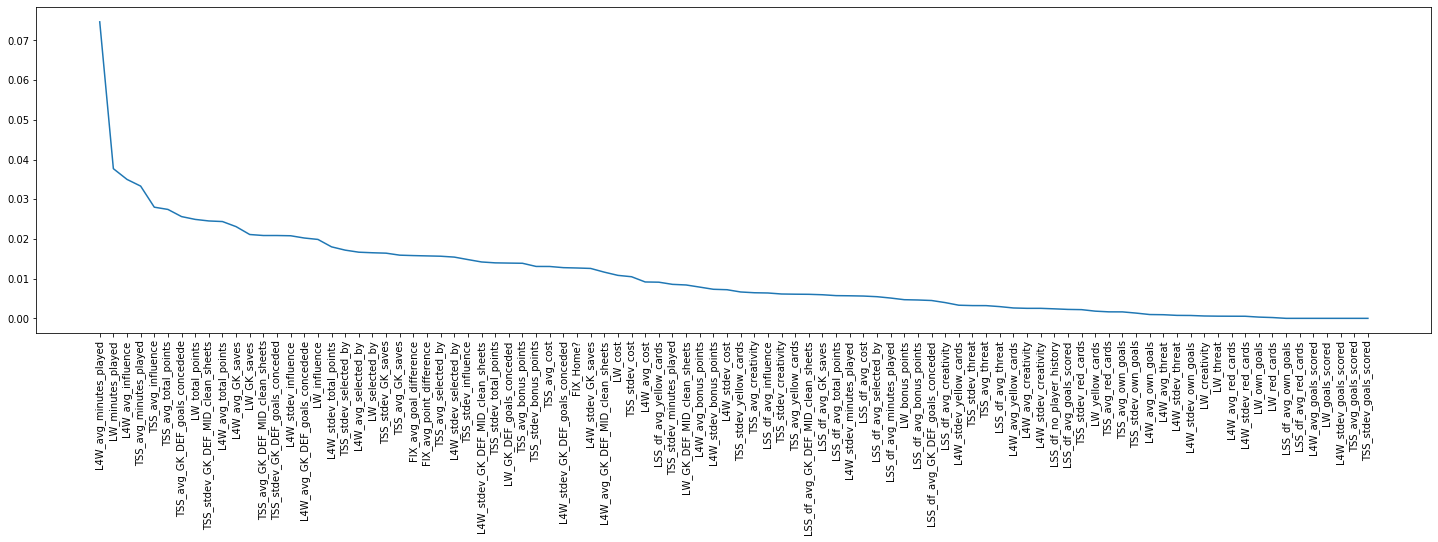

In [149]:
model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization

feat_importances = pd.Series(model.feature_importances_, index=X.columns)

plt.figure(figsize = [25,6])
plt.plot(feat_importances.sort_values(ascending = False))
plt.xticks(rotation=90)
plt.show()

## 5.2. Defender

In [150]:
X = historic_df_DEF[[c for c in historic_df_DEF.columns if str.startswith(c, ('FIX','LW','L4W','TSS','LSS'))]]
y = historic_df_DEF['TARGET_total_points']

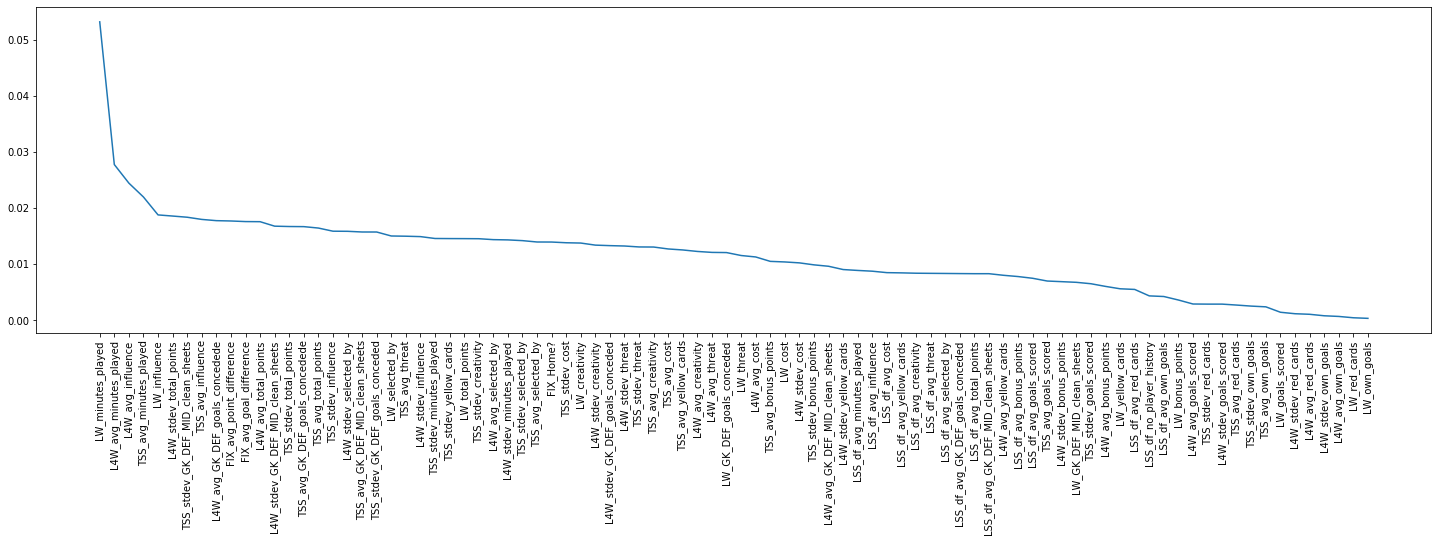

In [151]:
model = ExtraTreesClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)

#plot graph of feature importances for better visualization
plt.figure(figsize = [25,6])
plt.plot(feat_importances.sort_values(ascending = False))
plt.xticks(rotation=90)
plt.show()

## 5.3. Midfield

In [152]:
X = historic_df_MID[[c for c in historic_df_MID.columns if str.startswith(c, ('FIX','LW','L4W','TSS','LSS'))]]
y = historic_df_MID['TARGET_total_points']

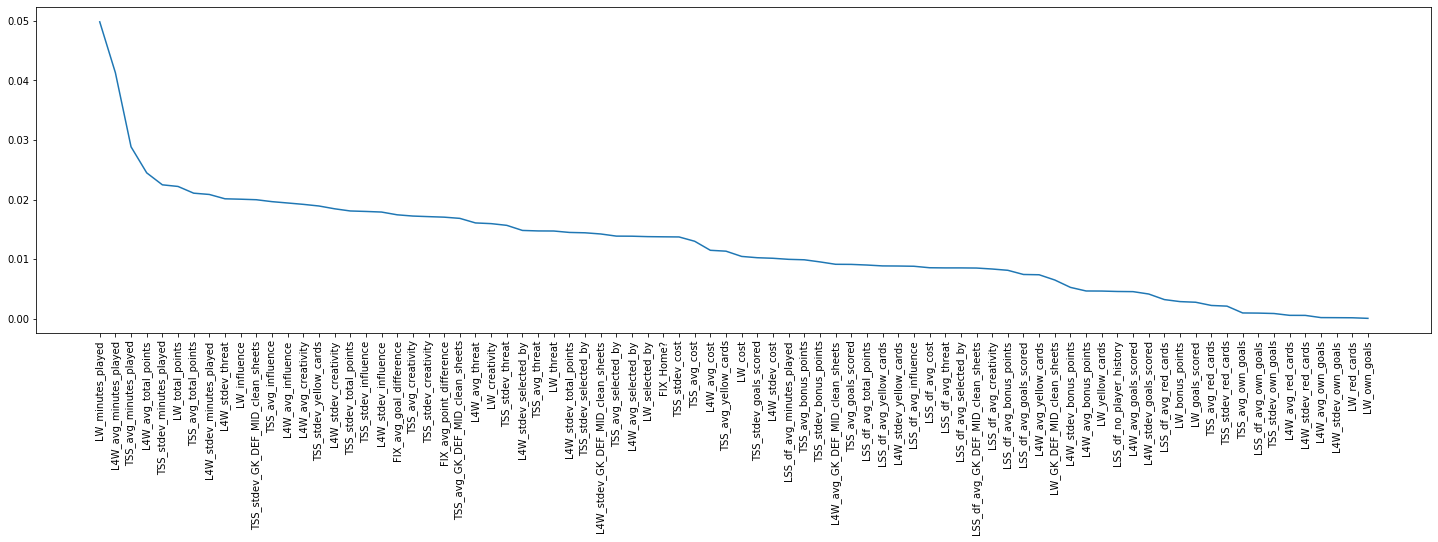

In [153]:
model = ExtraTreesClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)

#plot graph of feature importances for better visualization
plt.figure(figsize = [25,6])
plt.plot(feat_importances.sort_values(ascending = False))
plt.xticks(rotation=90)
plt.show()

## 5.4. Forward

In [154]:
X = historic_df_FOR[[c for c in historic_df_FOR.columns if str.startswith(c, ('FIX','LW','L4W','TSS','LSS'))]]
y = historic_df_FOR['TARGET_total_points']

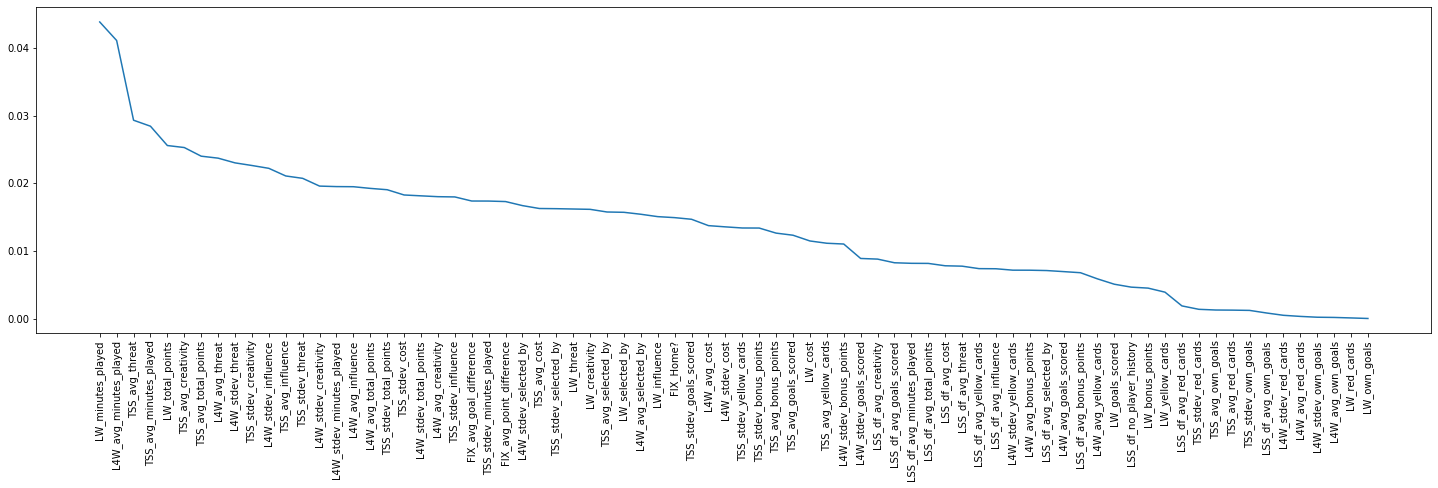

In [155]:
model = ExtraTreesClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)

#plot graph of feature importances for better visualization
plt.figure(figsize = [25,6])
plt.plot(feat_importances.sort_values(ascending = False))
plt.xticks(rotation=90)
plt.show()